### Face Swap with Assisted Detection

In [1]:
import numpy as np
import scipy as sc
import math
import cv2
import dlib
import os
import matplotlib.pyplot as plt
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

%matplotlib inline

#### Load two images, and covert them to grayscale. Each image has only one face. 

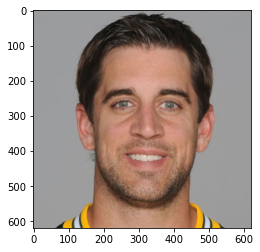

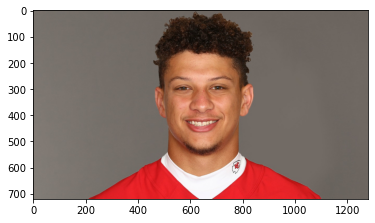

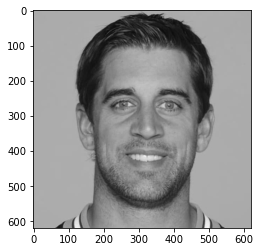

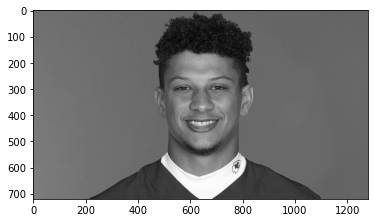

In [5]:
img1_path = 'rodgers.jpg'
im1_rgb = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(im1_rgb, cv2.COLOR_BGR2GRAY)

img2_path = 'mahomes.jpg'
im2_rgb = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2_rgb, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(im1_rgb)

plt.figure()
plt.imshow(im2_rgb)

plt.figure()
plt.imshow(im1, cmap='gray')

plt.figure()
plt.imshow(im2, cmap='gray')

#### Detect face for each image.

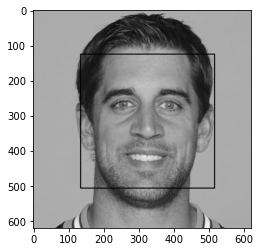

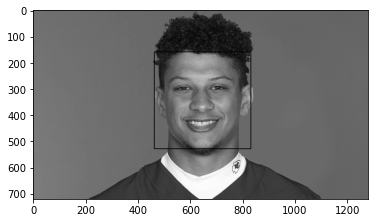

In [6]:
cascade1 = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces1 = cascade1.detectMultiScale(im1, scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))

for (x, y, w, h) in faces1:
    cv2.rectangle(im1, (x, y), (x+w, y+h), (0,0,255), 2)
    
plt.figure()
plt.imshow(im1,cmap='gray')

cascade2 = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces2 = cascade2.detectMultiScale(im2,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

for (x, y, w, h) in faces2:
    cv2.rectangle(im2, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.figure()
plt.imshow(im2,cmap='gray')

#### Face Featuring using dlib library.

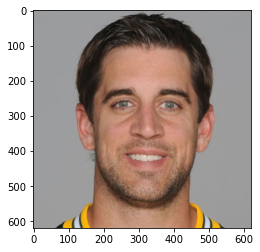

In [7]:
pred1 = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detect1 = dlib.get_frontal_face_detector()

im1_faces = detect1(im1.copy())
pts1 = np.zeros((len(im1_faces),3,68))

for n, face in enumerate(im1_faces):    
    lmks = pred1(im1.copy(), face)
    for i in range(0, 68):
        x = lmks.part(i).x
        y = lmks.part(i).y
        pts1[n,0,i] = x
        pts1[n,1,i] = y
        pts1[n,2,i] = 1
        cv2.circle(im1_rgb, (x, y), 4, (0, 0, 255), -1)
    
plt.imshow(im1_rgb.copy())


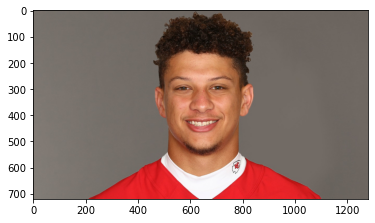

In [8]:
pred2 = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detect2 = dlib.get_frontal_face_detector()

im2_faces = detect2(im2.copy())
pts2 = np.zeros((len(im2_faces),3,68))

for n, face in enumerate(im2_faces):    
    lmks = pred2(im2.copy(), face)
    for i in range(0, 68):
        x = lmks.part(i).x
        y = lmks.part(i).y
        pts2[n,0,i] = x
        pts2[n,1,i] = y
        pts2[n,2,i] = 1
        cv2.circle(im2_rgb, (x, y), 4, (0, 0, 255), -1)
    
plt.imshow(im2_rgb.copy())

#### Homography computation between landmarks in two faces.

In [3]:
def computeHomography(pts1, pts2):
    
    temp1 = np.identity(3) 
    temp1[:,-1] = np.array([-np.mean(pts1[0,:]), -np.mean(pts1[1,:]), 1])
    std1 = np.diag(np.array([1/np.std(pts1[0,:]), 1/np.std(pts1[1,:]), 1]))
    pts1 = std1 @ (temp1 @ pts1)

    temp2 = np.identity(3) 
    temp2[:,-1] = np.array([-np.mean(pts2[0,:]), -np.mean(pts2[1,:]), 1])
    std2 = np.diag(np.array([1/np.std(pts2[0,:]), 1/np.std(pts2[1,:]), 1])) 

    pts2 = std2 @ (temp2 @ pts2)
    
    x, y = pts1.shape
    A = np.zeros((y*2, 9), dtype = np.float32)
    
    for i in range (0, y):
        p_0 = pts2[:,i]
        u_0 = p_0[0]/p_0[2]
        v_0 = p_0[1]/p_0[2]
        
        p = pts1[:,i]
        u = p[0]/p[2]
        v = p[1]/p[2]
        
        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_0, v*u_0, u_0]
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_0, v*v_0, v_0]
    U,S,V = svd(A)
    H = V[-1,:]
    H = np.reshape(H, (3, 3))
    H = (np.linalg.inv(temp2) @ (np.linalg.inv(std2) @ ((H@std1) @ temp1)))/H[2,2]
    return H

#### Warped face region from homography.

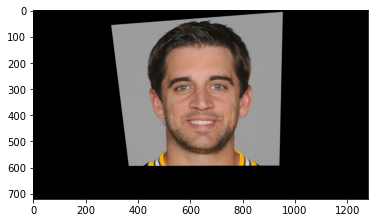

In [10]:
H12 = computeHomography(np.squeeze(pts1), np.squeeze(pts2))

h = im2_rgb.shape[0]
w = im2_rgb.shape[1]

warp1 = cv2.warpPerspective(im1_rgb, H12, (w,h))
plt.imshow(warp1)

#### Compute convex mask using cv2.ConvexHull and fillPoly.

In [4]:
def convex_mask(pts, img):
    
    lis = tuple(map(tuple, pts[0:2,:].T))
    convex_hull = [lis[i] for i in ConvexHull(lis).vertices]
    convex_hull.append((convex_hull[0][0], convex_hull[0][1]))
    convex_hull = np.array(convex_hull, dtype='int32')
    mask = np.zeros(img.shape[0:2],dtype=np.uint8)
    cv2.fillPoly(mask, [convex_hull], 1)
    
    return mask.astype(np.uint8)

#### Show face swap result.

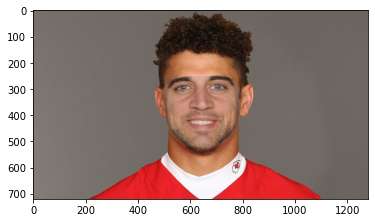

In [12]:
mask = convex_mask(pts2[0],im2_rgb)
swap = warp1*(mask[:,:,None].astype(int)) + im2_rgb*(1-mask[:,:,None].astype(int))
plt.imshow(swap)
plt.savefig('rodgers-mahomes_swap.jpg')

#### Load one image having two faces, and convert it to grayscale.

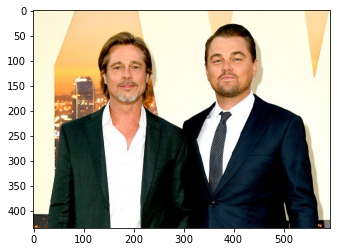

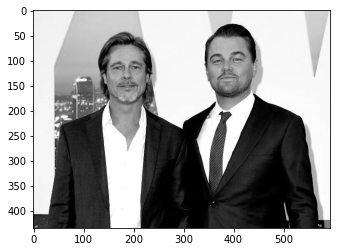

In [17]:
img_path = 'pitt-dicaprio.jpg'
img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img_rgb)

img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img, cmap='gray')

#### Face Detection.

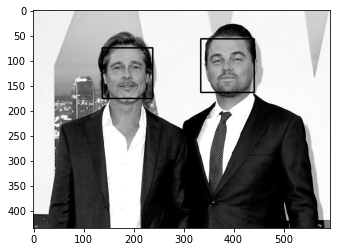

In [18]:
tf_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
tf_faces = tf_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))

for (x, y, w, h) in tf_faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.figure()
plt.imshow(img, cmap='gray')

#### Face Landmark.

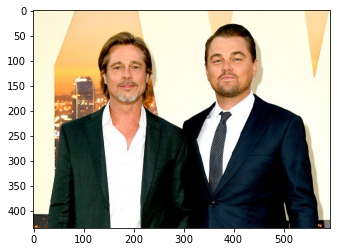

In [19]:
pred = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detect = dlib.get_frontal_face_detector()

two_faces = detect(img.copy())
pts = np.zeros((len(two_faces),3,68))

for n, face in enumerate(two_faces):
    lmks = pred(img.copy(), face)
    for i in range(0, 68):
        x = lmks.part(i).x
        y = lmks.part(i).y
        pts[n,0,i] = x
        pts[n,1,i] = y
        pts[n,2,i] = 1
        cv2.circle(img_rgb, (x, y), 4, (0, 0, 255), -1)
    
plt.imshow(img_rgb.copy())

#### Homography and mask computations.

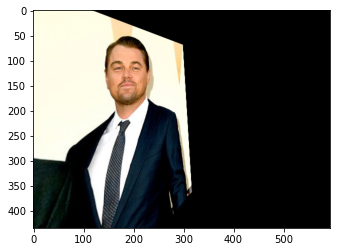

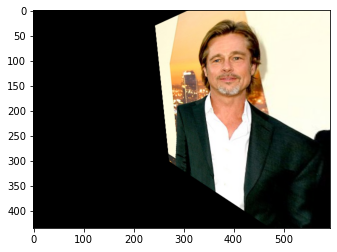

In [20]:
H12 = computeHomography(np.squeeze(pts[0]), np.squeeze(pts[1]))
H21 = computeHomography(np.squeeze(pts[1]), np.squeeze(pts[0]))

h = img_rgb.shape[0]
w = img_rgb.shape[1]

warp_face1 = cv2.warpPerspective(img_rgb, H12, (w,h))

plt.figure()
plt.imshow(warp_face1)

warp_face2 = cv2.warpPerspective(img_rgb, H21, (w,h))

plt.figure()
plt.imshow(warp_face2)

In [21]:
def convex_mask(pts, img):
    
    lis = tuple(map(tuple, pts[0:2,:].T))
    convex_hull = [lis[i] for i in ConvexHull(lis).vertices]
    convex_hull.append((convex_hull[0][0], convex_hull[0][1]))
    convex_hull = np.array(convex_hull, dtype='int32')
    mask = np.zeros(img.shape[0:2],dtype=np.uint8)
    cv2.fillPoly(mask, [convex_hull], 1)
    
    return mask.astype(np.uint8)

#### Blend and show the result.

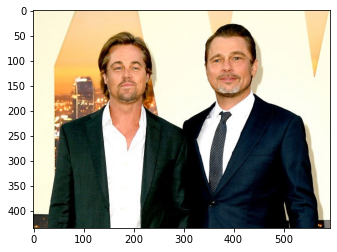

In [22]:
mask1 = convex_mask(pts[1],img_rgb)
mask2 = convex_mask(pts[0],img_rgb)
mask = np.bitwise_or(mask1,mask2)

swap = warp_face1*(mask1[:,:,None].astype(int)) + warp_face2*(mask2[:,:,None].astype(int)) + img_rgb*(1-mask[:,:,None].astype(int))
plt.imshow(swap)
plt.savefig(img_path + '_swap.jpg')

#### Real-time face swap.

In [5]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()
v = cv2.VideoCapture(0)

while True:
    _, frame = v.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    pts = np.zeros((len(faces),3,68))
    for i, face in enumerate(faces):    
        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            pts[i,0,n] = x
            pts[i,1,n] = y
            pts[i,2,n] = 1
    
    H12 = computeHomography(np.squeeze(pts[0]), np.squeeze(pts[1]))
    H21 = computeHomography(np.squeeze(pts[1]), np.squeeze(pts[0]))
    
    warp1 = cv2.warpPerspective(frame, H12, (frame.shape[1],frame.shape[0]))
    warp2 = cv2.warpPerspective(frame, H21, (frame.shape[1],frame.shape[0]))
    
    mask1 = convex_mask(pts[1],frame)
    mask2 = convex_mask(pts[0],frame)
    
    mask = mask1 + mask2
    
    frame = warp1*(mask1[:,:,None].astype(int)) + warp2*(mask2[:,:,None].astype(int)) + frame*(1-mask[:,:,None].astype(int))

    cv2.imshow("Frame", frame.astype(np.uint8))

    k = cv2.waitKey(35)
    if k == 30:
        break


IndexError: index 1 is out of bounds for axis 0 with size 1